In [20]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy


folder_path = './datas/100/'
pcanum = 20
tempnum = 200

In [8]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X.toarray())
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

In [2]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
adata_subset = datas[:tempnum,:]
adata_subset
sc.write('./datas/nature/adata_subset.h5',adata_subset)

In [3]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")
count_sub = datas.to_df()
xy_coords = datas.obs[['imagerow',"imagecol"]]
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

In [4]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4547 by 200

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 200 cells



  |======================================================================| 100%


R[write to console]: Found 20 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4547 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4547 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 4.406548 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |====================                                                  |  29%
  |                                                                            
  |==============================                                        |  43%
  |                                                                         

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  200 
## number of total features:  4547 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  27  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  27  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.292332161645348  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] 

/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_2704/3690497418.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata1.index = adata1.index.str.replace('.', '-')


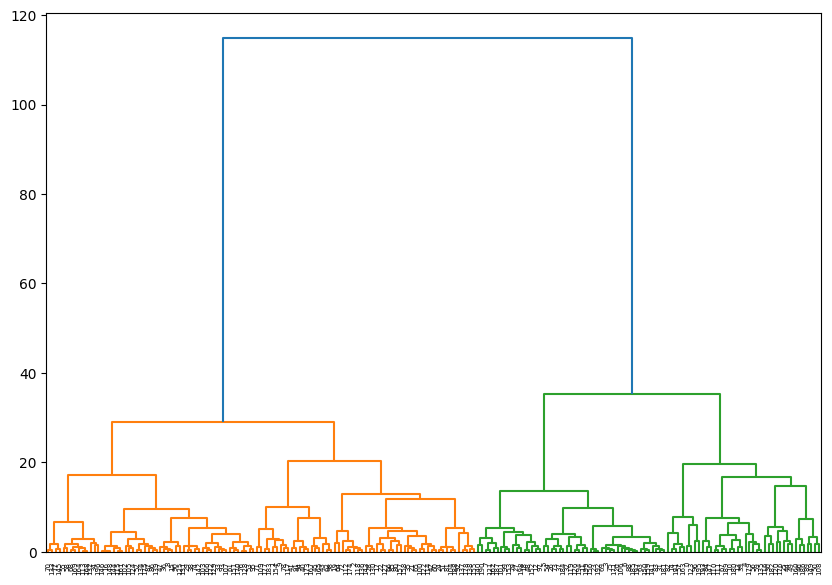

In [51]:
adata1 = pd.read_csv(folder_path+"pca.csv")
adata1 = adata1.set_index(adata1.columns[0]).T
adata1.index = adata1.index.str.replace('.', '-')
similarity_matrix = 1 - cosine_similarity(adata1)
n=len(similarity_matrix);
Z = hierarchy.linkage(similarity_matrix, 'ward')

plt.figure(figsize=(10, 7))
dn = hierarchy.dendrogram(Z)
plt.show()

# adata1 = anndata.AnnData(adata1)

# cell_meta = pd.read_csv(folder_path+"meta_data.csv")
# cell_meta = cell_meta.set_index(cell_meta.columns[0])
# adata1.obs = cell_meta
# adata1.obsm['X_pca'] = adata1.to_df()
# # # adata1.obs['celltype'] = cell_meta.values




In [52]:
Z[6]

array([ 76.         , 128.         ,   0.283565793,   2.         ])

In [54]:
nodes1 = [node(name=str(i),son=[]) for i in range(2*n-1)]
nodes1


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [74]:
nodes1 = [node(name=str(i),son=[]) for i in range(2*n-1)]
for i in range(n):
    nodes1[i].value = adata1.iloc[i].to_numpy()
for i in range(n-1):
    nodes1[n+i].son.append(nodes1[int(Z[i][0])])
    nodes1[n+i].son.append(nodes1[int(Z[i][1])])
    nodes1[n+i].value = nodes1[n+i].son[0].value  + nodes1[n+i].son[1].value
    nodes1[n+i].value /=2
nodes1

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [75]:
for i in range(len(nodes1)):
    print(nodes1[i].value)

[-0.8382089789 -0.1004083088  0.6683814071 -0.718965581  -0.2808907229
 -0.6082409965  0.5002680746  0.0174020417  0.167783445  -0.7603260178
 -0.5641957362  0.2465130398  0.1242813961  0.0069710042  0.0428486679
  0.0091287348 -0.1235367111  0.319749791  -0.3156837737  0.1469202901]
[ 0.4334920036  0.3637648345 -1.5027261924  0.0991578946 -0.5032194333
  0.183738227   0.4504389899 -0.0266963566 -0.0671604044  0.2557483486
  0.1635766681  0.2586414054 -0.3848342869 -0.2832850403  0.0668690327
 -0.147467383  -0.0357592077  0.324277406   0.1805709577 -0.0041897989]
[ 2.0657157135  0.1477130549  1.825777155  -0.212611377  -0.5243784612
 -1.0909750858 -0.4331048154 -0.0682182557 -0.1582310262  0.4696475241
 -0.0638557534  0.0197824322 -0.1067255585 -0.1803747408  0.0591726606
 -0.4106985543  0.0509394287  0.0172023399  0.0158892366  0.0380280547]
[-3.8085228181  0.3288907705  0.6874236919 -0.7111166623 -0.2245622337
  0.7769370419  0.0743133908 -0.5123809673  0.8378055809 -0.5123942818
  0

In [76]:
show_tree(nodes1[-1]).show_fig()
